# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

08/06/2021

## Integrantes

* Gustavo Heisser
* Agustin Rojas

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal
import sounddevice as sd
import soundfile as sf
import simpleaudio as sa
import wave
import scipy as sp
from scipy.io.wavfile import write

## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [3]:
def cargar_audio(filename): # VER ESTO SANTI
    
    """
    Genera un array con los datos de un archivo de audio en formato .wav
    
    Parametros
    ----------
    filename: str
        Nombre del archivo
    
    returns: NumPy array
        Datos del archivo leido.
    
    Ejemplo
    -------
        import soundfile as sf
        
        filename = 'ubicacion_archivo/nombre_archivo.wav'
        cargar_audio(filename)
    """
    
    data, fs = sf.read(filename, dtype='float32')
    
    return data

Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

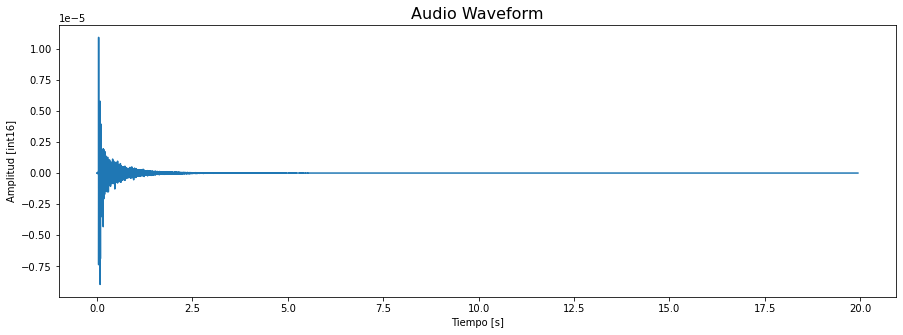

In [4]:
def visualizar (audioData, fs=44100):
    '''
        Funcion para visualizar audio
    '''

    length = audioData.shape[0] / fs
    t = np.linspace(0., length, audioData.shape[0])
    #t = np.arange(0, len(audioData), 1)/ fs
    
    plt.rcParams['figure.figsize'] = (15, 5) # set plot size
    #plt.plot(t, audioData)
    plt.plot(t, audioData / (2.**15))
    plt.title('Audio Waveform',size=16);
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [int16]")

filename = '../IR_samples/r1-nuclear-reactor-hall/mono/r1_omni.wav'
audio = cargar_audio(filename)
visualizar(audio)

> **Opcional**: el código de la siguiente celda genera un botón de selección (ver los pasos de instalación [aqui](https://ipywidgets.readthedocs.io/en/latest/user_install.html)), y guarda las rutas a los archivos seleccionados en la variable files. La función desarrollada debería tomar las rutas y leer el contenido de los archivos, utilizando alguna de las librerías vistas en clase.

In [23]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
files = []
def select_files(b,files=files):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    files.append(filedialog.askopenfilename()) # List of selected files will be set button's file attribute.
    print(files) # Print the list of files selected.

fileselect = Button(description="Seleccione el archivo")
#fileselect.on_click(select_files)

#display(fileselect)
#files

## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{π_{i}t}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
π_{i}=\frac{T_{60}}{\ln(10^{-3})}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60$ conocidos que permita probar el software.

In [6]:
def sintesis_RI(frecuencias, T_60, tiempo, fs=44100, amplitud=1):
    """
    Funcion de sintesis de respuesta al impulso
    
    Parametros
    ----------
    frecuencias: NumPy array
        Lista de frecuencias centrales
    T_60: NumPy array
        Lista de tiempos de reverberacion para cada frecuencia central
    tiempo: float
        Tiempo de duracion de la señal resultante.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    amplitud: float
        Coeficiente de amplitud de la señal. Por defecto el valor es 1.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un `.wav` con un numpy array de 10 segundos a partir de una 
    respuesta al impulso a partir de las frecuencias ingresadas y sus respectivos T60
    con frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        from scipy.io.wavfile import write
        
        frecuencias = np.array([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
        T_60 = np.array([2.15, 1.48, 1.63, 1.91, 2.08, 2.09, 1.82, 1.6, 1.18, 1.11])
        RI = sintesis_RI(frecuencias, T_60, 10)
    """
    
    n=fs*tiempo
    t = np.linspace(0,tiempo,n)
    decaimiento_exponencial = np.log(10**(-3))/T_60
    y = np.empty(1)
    for i in range(len(frecuencias)):
        y = y + (amplitud*np.exp(decaimiento_exponencial[i]*t)*np.cos(2*np.pi*frecuencias[i]*t))
    
    ## Normalizado
    valor_max = max(abs(max(y)),abs(min(y)))
    RI = y / valor_max
    RI = RI - RI[n-1]
    
    # Generación de archivo de audio .wav
    filename = '../IR_samples/RI.wav'
    write(filename, fs, RI)
    
    return RI 

Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

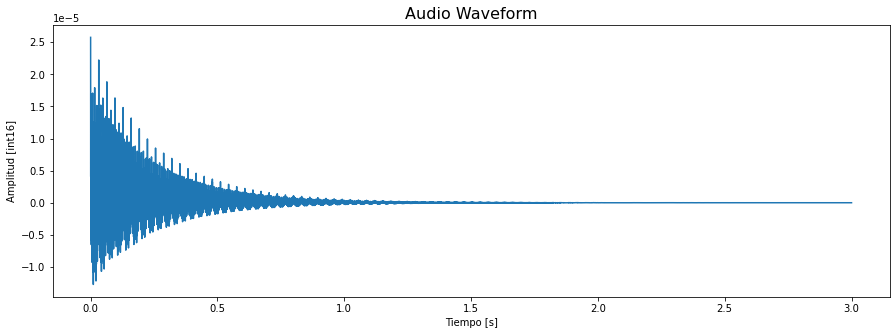

In [10]:
frecuencias = np.array([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])
T_60 = np.array([2.15, 1.48, 1.63, 1.91, 2.08, 2.09, 1.82, 1.6, 1.18, 1.11])

RI = sintesis_RI(frecuencias, T_60, 3)
visualizar(RI)

Reproducir señal resultante.

In [11]:
fs = 44100
sd.play(RI, fs)
sd.wait()

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

*completar*

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [21]:
def obtencion_RI(sine_sweep, filtro_inverso, fs=44100):
    """
    Funcion para obtener una respuesta al impulso a partir de un sine sweep logaritmico y su filtro inverso
    
    Parametros
    ----------
    sine_sweep : NumPy array
        Señal del sine sweep logaritmico.
    filtro_inverso : NumPy array
        Señal del filtro inverso.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar una respuesta al impulso a partir de un sine weep logaritmico y su filtro inverso..
    
        import numpy as np
        from scipy import signal
        from scipy.io.wavfile import write
        
        obtencion_RI(sine_sweep, filtro_inverso)
    """
    
    h_convolucion = signal.fftconvolve(sine_sweep, filtro_inverso)
    
    h_fourier = np.fft.ifft(np.fft.fft(sine_sweep)*np.fft.fft(filtro_inverso))

    # Generación de archivo de audio .wav
    filename = '../audio/obtencion_RI_convolucion.wav'
    write(filename, fs, h_convolucion)
    filename = '../audio/obtencion_RI_fourier.wav'
    write(filename, fs, h_fourier.real)
    
    return h_convolucion, h_fourier.real

Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

In [22]:
sine_sweep = cargar_audio('../audio/sinesweep.wav')
filtro_inverso = cargar_audio('../audio/filtroinverso.wav')

h_convolucion, h_fourier = obtencion_RI(sine_sweep, filtro_inverso)

Visualizar la señal con la función creada en la primer entrega.

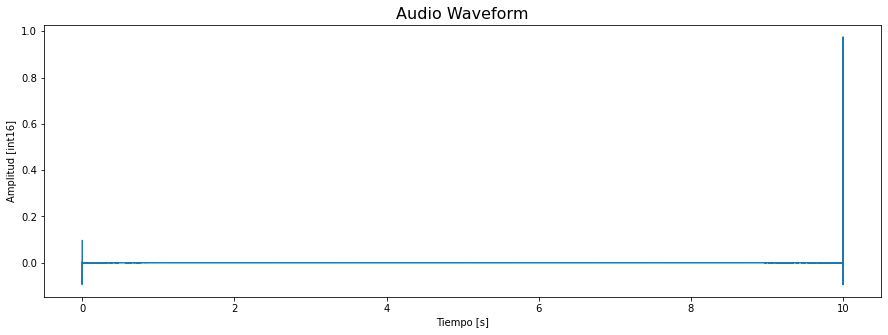

In [23]:
visualizar(h_fourier)

Reproducir señal resultante.

In [24]:
fs = 44100
sd.play(h_fourier, fs)
sd.wait()

Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

*completar*

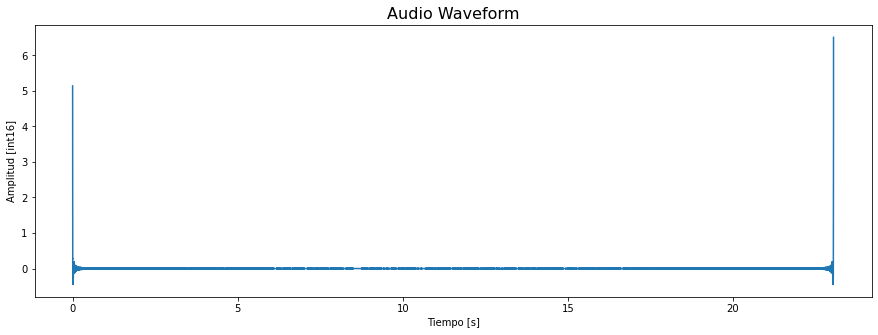

In [26]:
sine_sweep_descargado = cargar_audio('../audio/sine_sweep_descargado.wav')

fs = 44100
omega_inicial = 2*np.pi*20
omega_final = 2*np.pi*20000
n = len(sine_sweep_descargado)
T = n/fs
K = np.float16((T * omega_inicial) / np.log(omega_final/omega_inicial))
L = np.float16(T / np.log(omega_final/omega_inicial))
t = np.linspace(0,T,n)

# Funcion filtro inverso
w = ((K/L)*np.exp(sine_sweep_descargado/L))
m = (omega_inicial/(2*np.pi*w))
k = m*sine_sweep_descargado[::-1]
    
## Normalizado
valor_max = max(abs(max(k)),abs(min(k)))
filtro_inverso_descargado = k / valor_max
    
# Generación de archivo de audio .wav
filename = '../audio/filtro_inverso_descargado.wav'
write(filename, fs, filtro_inverso_descargado)
    
h_convolucion_2, h_fourier_2 = obtencion_RI(sine_sweep_descargado, filtro_inverso_descargado)
visualizar(h_fourier_2)

In [28]:
fs = 44100
sd.play(h_fourier_2, fs)
sd.wait()

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

*completar*

## Función filtros norma IEC61260

**Consigna**:Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

In [84]:
#Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
G = 1.0/2.0
factor = np.power(2, G)
fs = 44100
#Pruebo con una frecuencia central
centerFrequency_Hz = 1000

#Calculo los extremos de la banda a partir de la frecuencia central
lowerCutoffFrequency_Hz=centerFrequency_Hz/factor;
upperCutoffFrequency_Hz=centerFrequency_Hz*factor;

#Extraemos los coeficientes del filtro 
b,a = signal.iirfilter(4, [lowerCutoffFrequency_Hz,upperCutoffFrequency_Hz],
                            rs=60, btype='band', analog=False,
                            ftype='butter', fs=fs, output='ba') 

w, h = signal.freqz(b,a)
#plt.plot(w, 20 * np.log10(abs(h)), 'b')

#aplicar el filtro al array en la variable audio
#signal.sosfilter(sos, audio)

In [62]:
def filtros(audio):
    
    #Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
    G_octava = 1.0/2.0
    factor_octava = np.power(2, G_octava)
    G_tercio = 1.0/6.0
    factor_tercio = np.power(2, G_tercio)
    fs = 44100
    
    frecuencias_centrales = [31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000]
    frecuencias_centrales_tercios = [19.69, 24.8, 31.25, 39.37, 49.61, 62.5, 78.75, 99.21, 
                                    125, 157.5, 198.4, 250, 315, 396.9, 500, 630, 793.7, 1000, 1260, 
                                    1587, 2000, 2520, 3175, 4000, 5040, 6350, 8000, 10079, 12699, 16000]
    
    for i in frecuencias_centrales:
        lowerCutoffFrequency_Hz = i / factor_octava;
        upperCutoffFrequency_Hz = i * factor_octava;
        if i < 500:
            grado = 3
        elif i<4000:
            grado = 4
        else:
            grado = 6
        b,a = signal.iirfilter(grado, [lowerCutoffFrequency_Hz, upperCutoffFrequency_Hz],
                                rs=60, btype='band', analog=False,
                                ftype='butter', fs=fs, output='ba')
        w, h = signal.freqz(b,a)
        #plt.plot(w, 20 * np.log10(abs(h)), 'b')
        filtro = signal.lfilter(b, a, audio)
        # Generación de archivo de audio .wav
        filename = '../audio/filtro'+str(i)+'.wav'
        write(filename, fs, filtro)
        
    for i in frecuencias_centrales_tercios:
        lowerCutoffFrequency_Hz = i / factor_tercio;
        upperCutoffFrequency_Hz = i * factor_tercio;
        if i < 40:
            grado = 2
        elif i<500:
            grado = 3
        elif i<4000:
            grado = 4
        else:
            grado = 6
        b,a = signal.iirfilter(grado, [lowerCutoffFrequency_Hz, upperCutoffFrequency_Hz],
                                rs=60, btype='band', analog=False,
                                ftype='butter', fs=fs, output='ba')
        w, h = signal.freqz(b,a)
        #plt.plot(w, 20 * np.log10(abs(h)), 'b')
        filtro = signal.lfilter(b, a, audio)
        # Generación de archivo de audio .wav
        filename = '../audio/filtrotercio'+str(i)+'.wav'
        write(filename, fs, filtro)
        
    #aplicar el filtro al array en la variable audio
    #filtro = signal.lfilter(b, a, audio)
    #plt.plot(filtro, 'r', label='TF')
    #plt.legend(loc='best')
    #plt.show()

Llamar a la función con alguna RI generada anteriormente.

In [61]:
audio = cargar_audio('../audio/ruidoRosa.wav')

filtros(audio)

Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

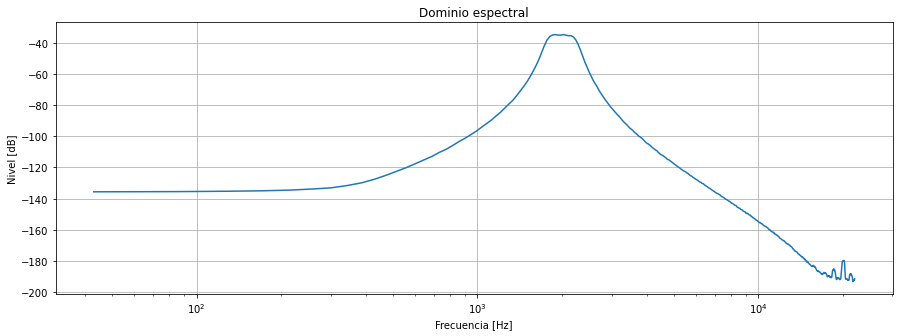

In [67]:
# Cambio de coma por punto
with open("../audio/espectro filtro 2000.txt") as f_input:

    text = [l.replace(",", ".") for l in f_input]

# Creo un array con los pares ordenados 
data = np.loadtxt(text, skiprows=1)

frecuencia, nivel = data.T
plt.semilogx(frecuencia,nivel)
plt.title('Dominio espectral')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Nivel [dB]")
plt.grid()

¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

*completar*

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [70]:
def conversion_logaritmica_normalizada(A, fs=44100):
    """
    Convierte una señal de respuesta al impulso en escala logaritmica.
    
    Parametros
    ----------
    A : NumPy array
        Señal que se desea transformar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Convertir una señal RI a escala logaritmica.
    
        import numpy as np
        from scipy.io.wavfile import write
        
        conversion_logaritmica_normalizada(RI)
    """
    
    R = np.array(20*np.log10(A/np.max(A)))
    
    # Generación de archivo de audio .wav
    filename = '../audio/señal_conversion.wav'
    write(filename, fs, R)
    
    return R

Llamar a la función con alguna de las señales generadas anteriormente.

In [71]:
RI = cargar_audio('../IR_samples/usina-del-arte-symphony-hall/mono/ir_posic2-pb.wav')

R = conversion_logaritmica_normalizada(RI)
RI

<ipython-input-70-78be50ae5dc8>:25: RuntimeWarning: divide by zero encountered in log10
  R = np.array(20*np.log10(A/np.max(A)))
<ipython-input-70-78be50ae5dc8>:25: RuntimeWarning: invalid value encountered in log10
  R = np.array(20*np.log10(A/np.max(A)))


array([ 1.3427734e-03,  1.3732910e-03,  1.3732910e-03, ...,
       -3.0517578e-05,  1.5258789e-04,  9.1552734e-05], dtype=float32)

Visualizar la señal con la función creada en la primer entrega.

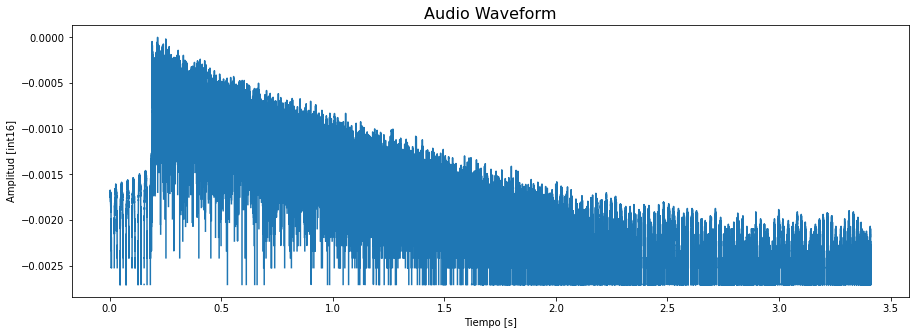

In [72]:
visualizar(R)

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |